# Imports

In [31]:
!pip install shap
!pip install fastcluster


In [32]:
# Basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter

# Machine Learning preprocessing and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Specific model import
import xgboost as xgb

# Imbalanced dataset handling
from imblearn.over_sampling import SMOTE

# Optional: Advanced dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# Model explanability
import shap
import fastcluster

In [33]:
# reading data
Data = "dataset.csv"
df = pd.read_csv(Data)

In [34]:
# Drop unrelevant columns
columns_to_drop = ['encounter_id', 'patient_id', 'icu_id', 'Unnamed: 83']
df = df.drop(columns=columns_to_drop)

# Drop rows with null values in the target feature (hospital_death)
df = df.dropna(subset=['hospital_death'])

# Split target values from other features
X = df.drop(columns=['hospital_death'])
y = df['hospital_death']

In [35]:
columns = X.columns
categorical_columns = ['hospital_id','ethnicity', 'icu_admit_source', 'icu_type', 'icu_stay_type', 'gcs_eyes_apache', 'gcs_motor_apache',
                       'gcs_verbal_apache', 'apache_3j_bodysystem', 'apache_2_bodysystem']
binary_columns = ['elective_surgery', 'gender', 'apache_post_operative',  'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',
                  'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
numeric_columns =  [col for col in X.columns if col not in categorical_columns + binary_columns]

# Outliers

Outliers can significantly affect the performance of the machine learning model. They can distort the overall distribution of the data, leading to biased model estimates and poor generalization to new data.

Let's examine the distribution of our numeric feature values using box plots.

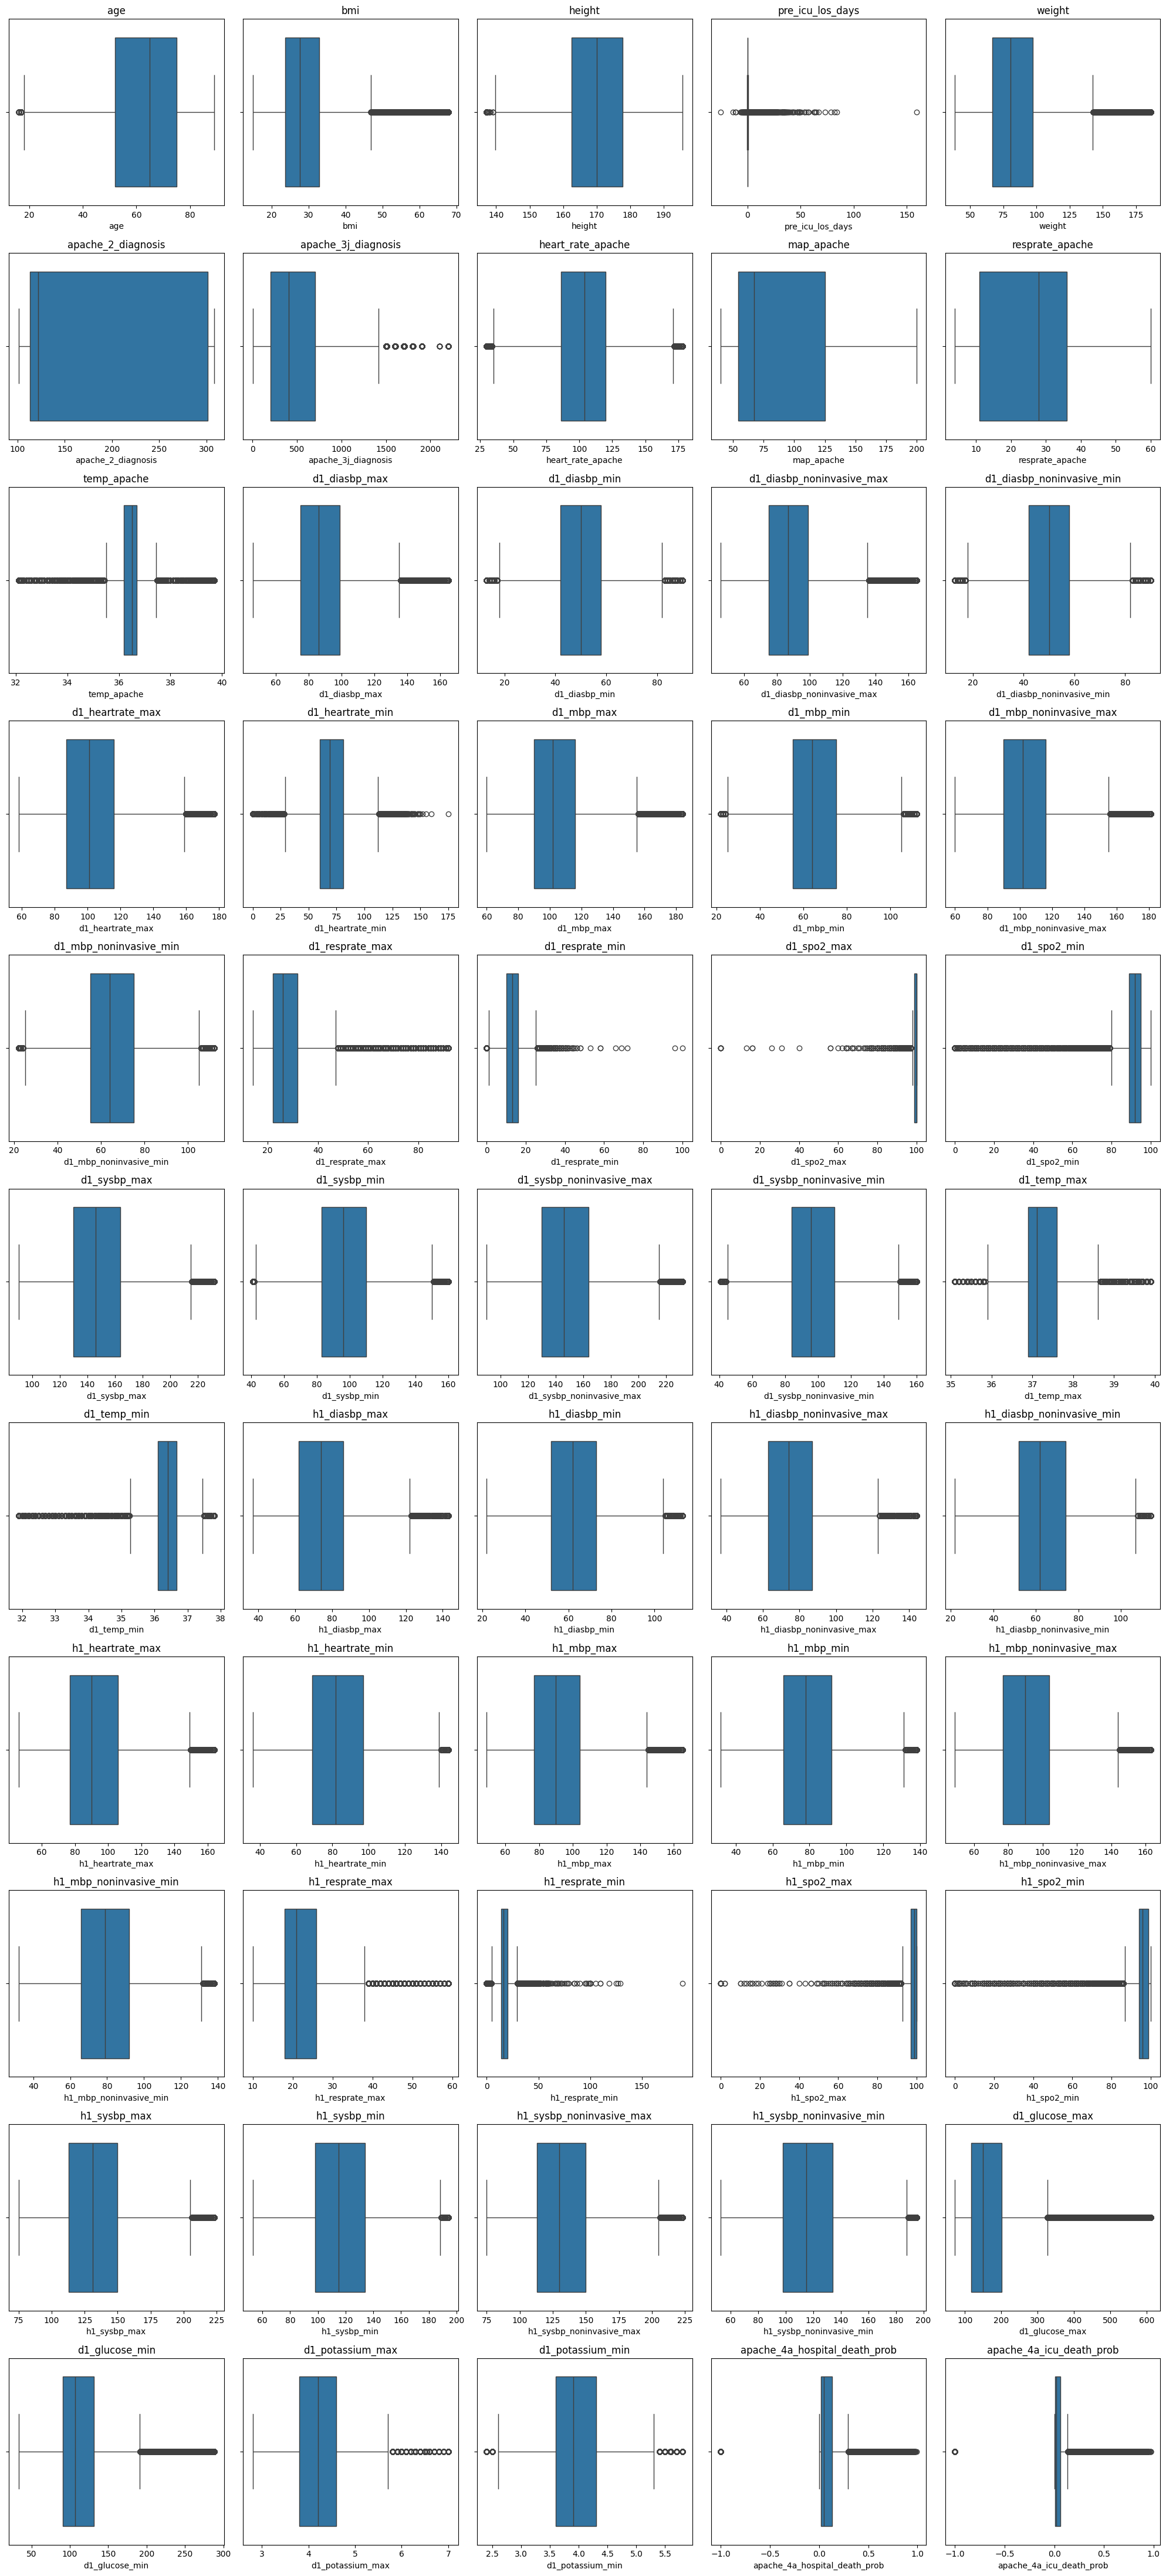

In [36]:
# Setting the number of columns in the grid of subplots
ncols = 5
# Calculating the required number of rows based on the number of numerical columns
nrows = (len(numeric_columns) + ncols - 1) // ncols

# Setting the size of the entire figure (width, height in inches)
plt.figure(figsize=(ncols * 4, nrows * 4))

for i, col in enumerate(numeric_columns):
    # Adding a subplot for each numerical column
    plt.subplot(nrows, ncols, i + 1)
    # Using seaborn to create the boxplot
    sns.boxplot(x=X[col])
    plt.title(col)

plt.tight_layout()
plt.show()

As we can see, there is an outliers problem in all the features and there are many features to address.
We suspect that several features in our dataset exhibit significant skewness (there is a long tail), therefore we may have outliers. Let's start by visualizing these distributions.

# Skewness

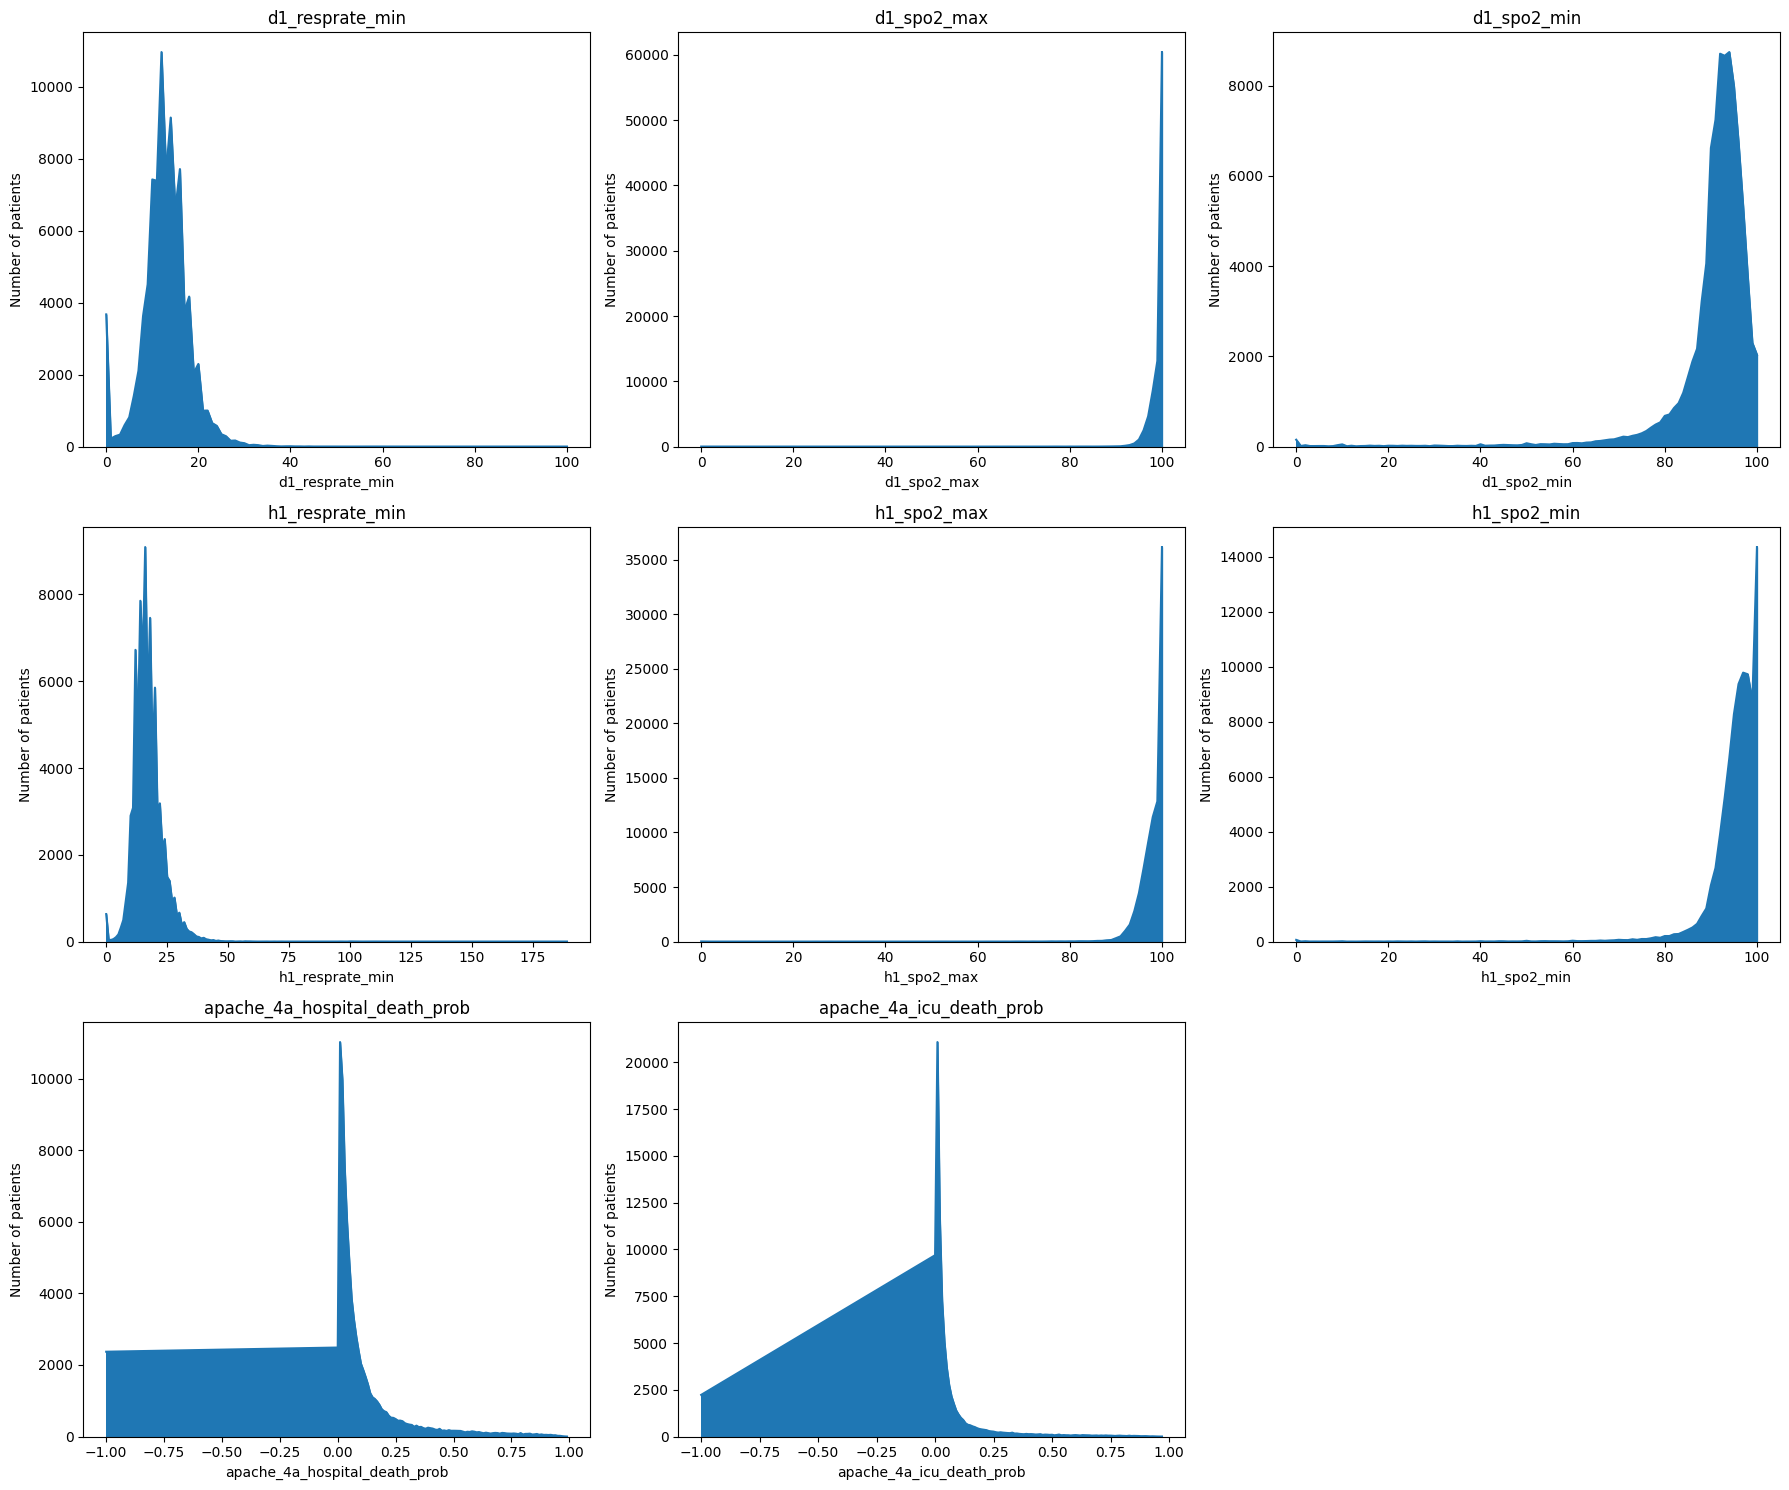

In [37]:
def plot_feature_distributions(dataframe, features, cols=3):
    # Number of features determines the number of rows and columns in the grid
    nrows = int(np.ceil(len(features) / cols))

    # Create a figure with subplots in a grid defined by nrows and cols
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(cols * 6, nrows * 5))

    # Flatten axes array for easy iteration in case of one row or column
    axes = axes.flatten()

    # Loop through the features and create an area plot for each one
    for i, feature in enumerate(features):
        # Plot the value counts as an area plot, sorted by the index, on respective subplot
        dataframe[feature].value_counts().sort_index().plot.area(ax=axes[i], title=feature)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Number of patients')

    # If there are more subplots than features, turn off the extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

selected_features = ['d1_resprate_min','d1_spo2_max', 'd1_spo2_min', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']
plot_feature_distributions(X, selected_features)

# Examining the target feature - Imbalance of the target: 'hospital_death'

Amount of two classe in 'hospital death': 
 hospital_death
0    83798
1     7915
Name: count, dtype: int64 




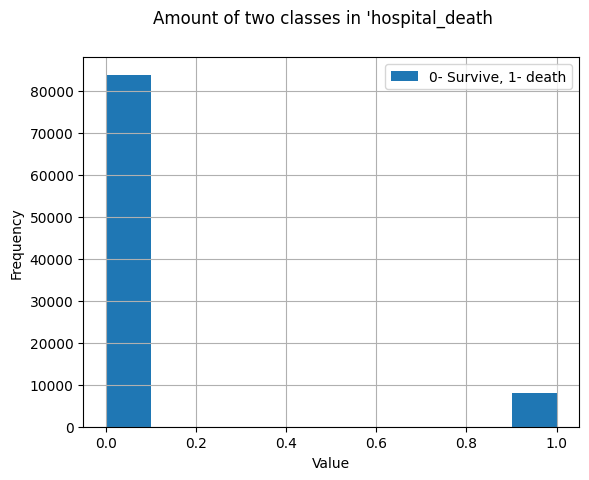

In [38]:
# Imbalance of the target: 'hospital_death'
Data_count = y.value_counts()
print(f"Amount of two classe in 'hospital death': \n {Data_count} \n\n")

# Visualize two classes in 'hospital_death'
Data_hist = y.hist()
plt.suptitle("Amount of two classes in 'hospital_death")
plt.xlabel("Value")
plt.ylabel("Frequency")
Data_hist.legend(["0- Survive, 1- death"])


In [39]:
# calculating proportion between control values and case values
print(f"Proportion of two classe in 'hospital death': {Data_count[0]/Data_count[1]}")

Proportion of two classe in 'hospital death': 10.587239418825016


Explanation: We can see that the target feature- hospital death is highly unbalanassed. It might impact the model performings or biased the results. We will need to dell with that, and to consider to balance the data with difference methods in order to get reliable results.

# Examining Correlations to the target feature

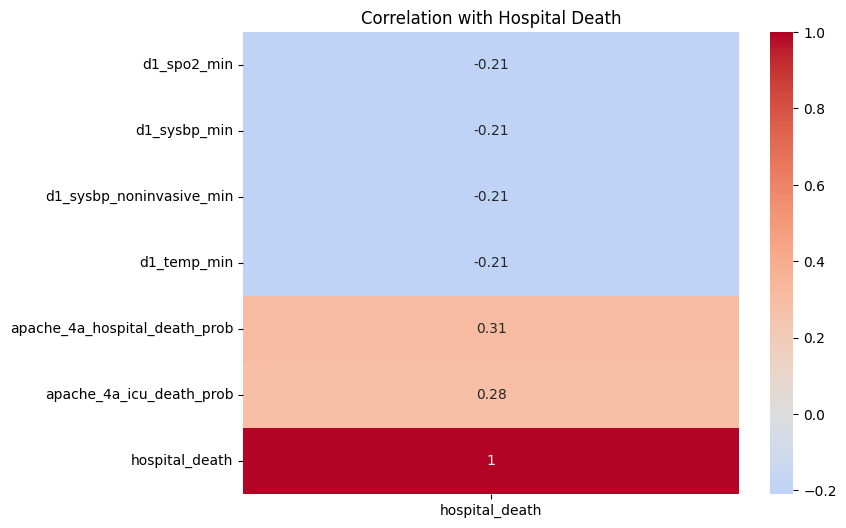

In [40]:
# Concatenate X_train and y_train for correlation calculation
data = pd.concat([X[numeric_columns], y], axis=1)

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Filter the correlation matrix to only show features with correlation to 'hospital_death' <= -0.2 or >= 0.2
target_correlation = correlation_matrix.loc[:, ['hospital_death']]
significant_correlations = target_correlation[(target_correlation['hospital_death'] <= -0.2) | (target_correlation['hospital_death'] >= 0.2)]

# Plotting the significant correlations
plt.figure(figsize=(8, 6))
sns.heatmap(significant_correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with Hospital Death')
plt.show()

the above figure displays a correlation matrix that highlights only the features which have a correlation coefficient of less than -0.2 or greater than 0.2 with the target feature 'hospital death'.

we decided to delete the 2 most correlated features:
'apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob'
which both are death probabilities, that can effect and bias the model prediction.

In [41]:
X = X.drop(columns=['apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob'])

# Update the list of numeric columns after dropping the columns
numeric_columns = [col for col in X.columns if col not in categorical_columns + binary_columns]

# Interaction between age, gender, and hospital death

In [42]:
# Assuming y_train is a Series, you should ensure it has an appropriate name for merging
y_train_named = y.rename('hospital_death')

# Merge X_train with y_train using the index
X_train_with_target = X.join(y_train_named)

# creating histogram of interaction between age, gender, and the target feature
fig = px.histogram(X_train_with_target[['age', 'gender', 'hospital_death']].dropna(), x= "age", y = "hospital_death", color = 'gender',
                  marginal = 'box', title= "Interaction between age, gender, and hospital death")


fig.show()

Explanation: We examine the impact of the gender feature, the age feature, and the interaction between both, on the target value.
We can relate to the following insights:
1. It seems that Woman has lowest hospital survival rate than men.
2. It seems that between the age of 50 and 60, the hospital survival rate begin to drop.
3. It seems that for woman, the affect of age on the surviving rate is starting at the age of 50, and along men at the age of 60.

# Data Preprocessing

To ensure that the machine learning pipeline avoids data leakage and maintains the integrity of the training and testing processes, we start with spliting the data into training and test sets before undertaking any kind of data preprocessing, such as imputation, normalization, or encoding.

In [43]:
# dividing the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Handling missing values, encoding the categorical and binary features and normalized the values in the numerical features.

In [44]:
# Defining Pre-processor pypline
preprocessor = ColumnTransformer(transformers=[
        ('numeric', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),        # Handling missing values
            ('scaler', StandardScaler())                          # Normalized numeric columns
        ]), numeric_columns),
        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling missing values
            ('encoder', OneHotEncoder(handle_unknown='ignore'))   # Encoding categorical columns
        ]), categorical_columns),
        ('binary', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling missing values
            ('encoder', OrdinalEncoder())                        # Encoding binary columns
        ]), binary_columns)
    ],
    remainder='passthrough'  # Keep any columns not explicitly specified in the transformers
)


# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Getting columns names
new_columns = preprocessor.get_feature_names_out()

In [45]:
# Getting the feature shape after one hot encoder
print(X_train_transformed.shape)

(73370, 273)


After applying one-hot encoding,  the dimensions have increased even further.

We will need to perform feature selection and dimensionality reduction later.

# Basic ML pipeline - Performing Learning and evaluation of the model

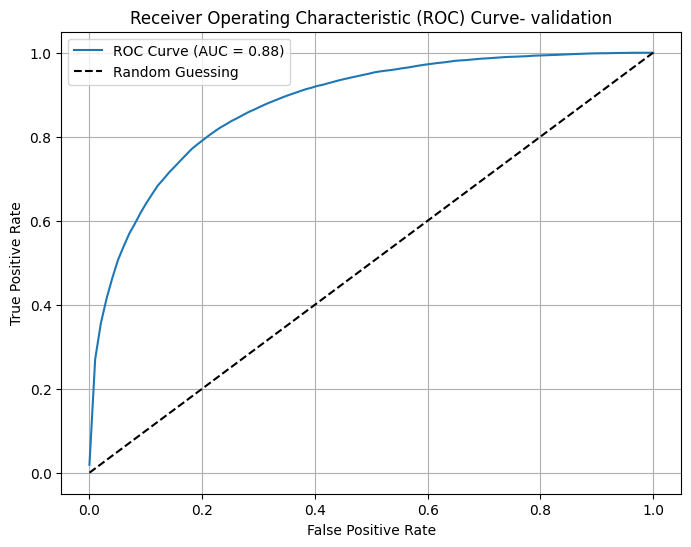

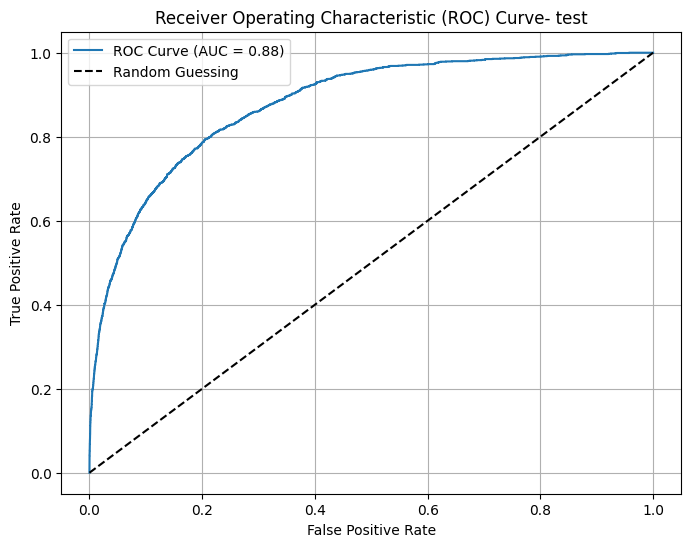

In [46]:
# Performing an XGBoost classifier

# defining model
model = xgb.XGBClassifier(random_state=42)

# performing 10-cross validation process
cv_auc_scores = []
interpolated_fpr_scores = []
interpolated_tpr_scores = []

counter = 0

while counter < 10:
  # dividing to validation and training sets
  X_valid_train_transformed, X_valid_test_transformed, y_valid_train, y_valid_test = train_test_split(X_train_transformed, y_train, test_size=0.2)

  # training the model
  model.fit(X_valid_train_transformed, y_valid_train)

  # Predict probabilities on the test set
  y_pred = model.predict_proba(X_valid_test_transformed)
  y_valid_pred_binary = model.predict(X_valid_test_transformed)

  # Compute AUC score for this fold

  auc_score = roc_auc_score(y_valid_test, y_pred[:, 1])
  cv_auc_scores.append(auc_score)

  fpr, tpr, thresholds = roc_curve(y_valid_test, y_pred[:,1])
  interpolated_fpr = np.linspace(0, 1, 100)  # Define the desired number of points for FPR
  interpolated_tpr = np.interp(interpolated_fpr, fpr, tpr)  # Interpolate TPR values
  interpolated_fpr_scores.append(interpolated_fpr)
  interpolated_tpr_scores.append(interpolated_tpr)

  counter += 1

# compute mean AUC, fpr, tpr
mean_auc = np.mean(cv_auc_scores)
mean_fpr = np.mean(interpolated_fpr_scores, axis=0)
mean_tpr = np.mean(interpolated_tpr_scores, axis=0)

# Examine the model performance on test set
y_pred_test = model.predict_proba(X_test_transformed)
y_pred_test_binary = model.predict(X_test_transformed)
auc_score_test = roc_auc_score(y_test, y_pred_test[:, 1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])

# Plot ROC curve

# mean validation sets
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label='ROC Curve (AUC = {:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- validation')
plt.legend()
plt.grid(True)
plt.show()

# test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label='ROC Curve (AUC = {:.2f})'.format(auc_score_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- test')
plt.legend()
plt.grid(True)
plt.show()



We decided to evaluate our model using AUC scoring method, as it particularly powerful method for evaluating classifiers on imbalanced and skewed datasets due to its insensitivity to class distribution.

We can see that we have nice results by the xgboost model (after a only basic pre-processing).
From the exploration data pare, we learn that:
1. The data is highly imbalance.
2. We have a lot of ouliers values in the numeric features.
3. We have a large amount of features, increased with the pre-processing that includes one-hot-encoding.
We will need to handle those issues in the next step, in order to improve the results of the model and make sure it reliable.

# **Improving the basic pipeline**

The clinical/medical data we worked on was particularly complex and challenging for several reasons.

First, due to its large size and the extensive number of dimensions involved. High-dimensional data poses unique challenges in terms of analysis and interpretation.

Second, the complexity of the features and their non-uniform distribution, often exhibiting significant skewness.

Third, the dataset was highly imbalanced.

 These factors primarily contributed to substantial computational complexity.

Our main efforts in developing the model were focused on extensive research and review of relevant literature to identify the most effective machine learning techniques and pipelines for managing the intricacies of our data.

We implemented advanced feature selection and dimensionality reduction methods to construct a robust model that avoids overfitting and can generalize effectively for real-world scenarios.

The pipline we developed to improve model performance:
1. Trying another ML model
2. Handeling outliers
3. Handling imbalance data
4. Exploring feature importance & Feature selection
5. Error analysis
6. Dimensionality reduction
7. Hyper-parameters tuning
8. Model explanability


# 1- Choose model

First, we have tried an alternative supervised machine-learning model, to compare and choose the one with the best performance.
We chose the AdaBoost (Adaptive Boosting), an ensemble learning method that combines multiple weak learners to create a strong learner. The weak learners will be the Decision Tree with shallow depth (we chose the max depth to be 1).
We used the same evaluation matrix: AUC and ROC curve, so that we could compare between the results of the basic models.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estim

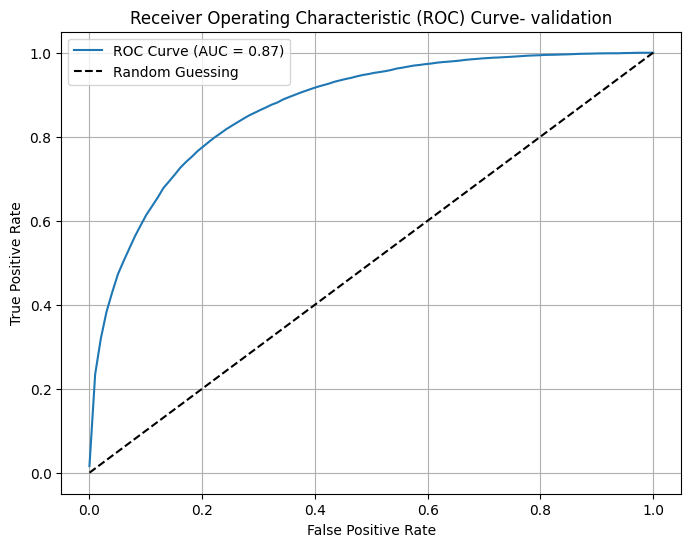

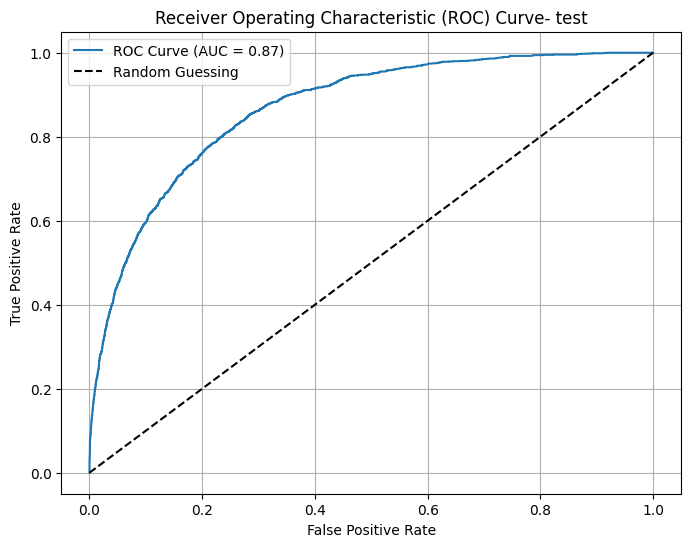

In [47]:
# Performing an adaBoost classifier

# defining model
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_estimator = base_model, n_estimators=50)

# performing 10-cross validation process
cv_auc_scores = []
interpolated_fpr_scores = []
interpolated_tpr_scores = []

counter = 0

while counter < 10:
  # dividing to validation and training sets
  X_valid_train_transformed, X_valid_test_transformed, y_valid_train, y_valid_test = train_test_split(X_train_transformed, y_train, test_size=0.2)

  # training the model
  adaboost_model.fit(X_valid_train_transformed, y_valid_train)

  # Predict probabilities on the test set
  y_pred = adaboost_model.predict_proba(X_valid_test_transformed)

  # Compute AUC score for this fold

  auc_score = roc_auc_score(y_valid_test, y_pred[:, 1])
  cv_auc_scores.append(auc_score)

  fpr, tpr, thresholds = roc_curve(y_valid_test, y_pred[:,1])
  interpolated_fpr = np.linspace(0, 1, 100)  # Define the desired number of points for FPR
  interpolated_tpr = np.interp(interpolated_fpr, fpr, tpr)  # Interpolate TPR values
  interpolated_fpr_scores.append(interpolated_fpr)
  interpolated_tpr_scores.append(interpolated_tpr)

  counter += 1

# compute mean AUC, fpr, tpr
mean_auc = np.mean(cv_auc_scores)
mean_fpr = np.mean(interpolated_fpr_scores, axis=0)
mean_tpr = np.mean(interpolated_tpr_scores, axis=0)

# Examine the model performance on test set
y_pred_test = adaboost_model.predict_proba(X_test_transformed)
auc_score_test = roc_auc_score(y_test, y_pred_test[:, 1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])

# Plot ROC curve

# mean validation sets
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label='ROC Curve (AUC = {:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- validation')
plt.legend()
plt.grid(True)
plt.show()

# test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label='ROC Curve (AUC = {:.2f})'.format(auc_score_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- test')
plt.legend()
plt.grid(True)
plt.show()

We can see that the XGboost performance are similar(and a little bit better) as the Adaboost. We will continue the following processing regarding this model.

# 2- Handeling Outliers

In [48]:
print("Original DataFrame shape:", X_train.shape)

# Initialize a counter for outliers
outliers_count = 0

# Define the columns to include specifically for outlier handling
include_columns = ['h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
                   'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min',
                   'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_diasbp_max',
                   'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min']

# Applying IQR method for outlier handling
for col in include_columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the cutoffs for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace values beyond the IQR with NaN or with the upper/lower bounds
    # Here we replace with NaN and later impute these NaNs with the median of the column
    original_train_col_data = X_train[col].copy()  # Copy original data for comparison
    X_train.loc[X_train[col] < lower_bound, col] = np.nan
    X_train.loc[X_train[col] > upper_bound, col] = np.nan

    # Count how many values were modified
    outliers_count += (original_train_col_data < lower_bound).sum()
    outliers_count += (original_train_col_data > upper_bound).sum()

# After handling outliers, you can choose to impute the NaNs created
# For example, imputing with median:
imputer = SimpleImputer(strategy='median')
X_train[include_columns] = imputer.fit_transform(X_train[include_columns])

print("Filtered DataFrame shape after handling outliers:", X_train.shape)
print(f'Number of outliers modified: {outliers_count}')

Original DataFrame shape: (73370, 78)
Filtered DataFrame shape after handling outliers: (73370, 78)
Number of outliers modified: 11861


As shown in the outlier analysis earlier in the report, we are dealing with skewed data characterized by numerous outliers.

Given the nature of the clinical data under analysis, it is crucial to approach outlier handling with caution.

This is because some clinical features inherently contain valid extreme values that are essential for accurate predictions.
Capturing and analyzing extreme fluctuations in vital signs is vital for early intervention and predicting critical.
For these reasons, we have decided to exclude features related to medical settings from outlier deletion.

We adopted the Interquartile Range (IQR) method for outlier management because it is recognized as a moderately aggressive approach, particularly effective for datasets exhibiting skewed distributions, similar to our data. This method was chosen because it robustly identifies outliers based on the quartile spread, which adjusts to the asymmetry of the data distribution.

For the outlier handling process, we strategically selected only certain features that demonstrated significant variability upon visual inspection of their distributions. This targeted approach ensures that our outlier management is both effective and preserves the integrity of critical data characteristics.

[citation:
Qiao, H., Chen, Y., Qian, C. et al. Clinical data mining: challenges, opportunities, and recommendations for translational applications. J Transl Med 22, 185 (2024). https://doi.org/10.1186/s12967-024-05005-0 ]

[citation:
Yoon JH, Jeanselme V, Dubrawski A, Hravnak M, Pinsky MR, Clermont G. Prediction of hypotension events with physiologic vital sign signatures in the intensive care unit. Crit Care. 2020 Nov 25;24(1):661. doi: 10.1186/s13054-020-03379-3. PMID: 33234161; PMCID: PMC7687996.]

**Applying the preprocessor again after deleting the outliers:**

In [49]:
# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Getting columns names
new_columns = preprocessor.get_feature_names_out()

In [50]:
# Evaluate the model's predictive results in a 10 fold cross-validation process after applying outlier handling
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = ['accuracy', 'roc_auc']
cv_results = cross_validate(model, X_train_transformed, y_train, cv=cv, scoring=scoring)

print(f"Accuracy mean: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Roc Auc mean: {np.mean(cv_results['test_roc_auc']):.4f}")

Accuracy mean: 0.9262
Roc Auc mean: 0.8788


After removing the selected outliers and running a 10-fold cross-validation check, we can see we havn't improved our model performance, yet it didn't decreased.

# 3- Data Imbalance


As shown earlier in the report, the datased is highly imbalanced. There are many more patients who did not experience in-hospital death than cases of in-hospital death.

Let's check if the model did predict an imbalanced results:

In [51]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Generate cross-validated predictions for the training set using the transformed features
y_pred = cross_val_predict(model, X_train_transformed, y_train, cv=cv)

# Print classification report to see the performance on each class
print("Classification Report:")
print(classification_report(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     67042
           1       0.64      0.32      0.43      6328

    accuracy                           0.93     73370
   macro avg       0.79      0.65      0.69     73370
weighted avg       0.91      0.93      0.91     73370



As we see the model has shown better performance for “0” label than “1” due to an unbalanced dataset.

This class imbalance can lead to biased models that favor the majority class and perform poorly in predicting the minority class.

We use SMOTE to address this problem,as is it a popular technique used to address class imbalance by oversampling the minority class.

In [52]:
# appling SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)


By balancing the dataset first, prior to conducting feature selection and dimensionality reduction, we ensure that the feature selection process considers the predictive importance of features across all classes more equitably, not favoring features that are more predictive of the majority class.

In [53]:
# Evaluate the model's predictive results in a 10 fold cross-validation process after dealing with imbalance data

cv_results = cross_validate(model, X_train_smote, y_train_smote, cv=cv, scoring=scoring)

print(f"Accuracy mean: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Roc Auc mean: {np.mean(cv_results['test_roc_auc']):.4f}")

Accuracy mean: 0.9600
Roc Auc mean: 0.9891


After handling with imbalance data we can see that the model performance has been sighnifically improved. The high score (0.98) can imply on overfitting, which may occur due to the large number of features.

Our next step is performing a feature selection and dimensionality reduction.

In addition, in the following steps we will add L2 regularization to our improving model in order to deal with this scenario.

# 4- Exploring feature importance & performing feature selection


Since we have a large number of features, we want to get a "feeling" regarding their relative contribution to the model. This will help us to understand if we have some consistent fields with significant impact on our model.

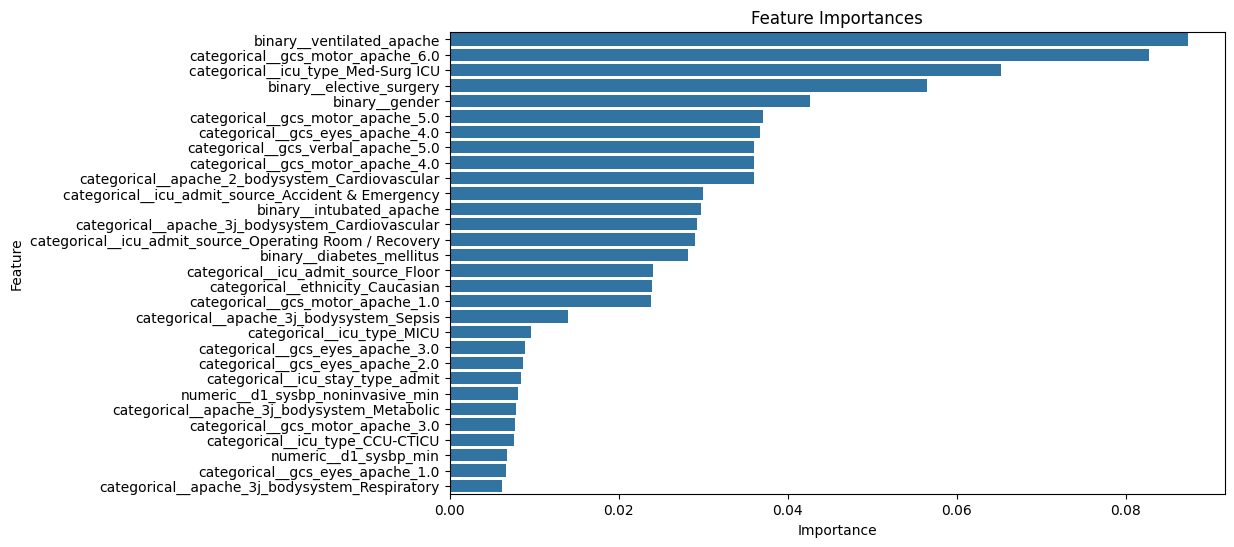

In [54]:
model.fit(X_train_smote,y_train_smote)
feature_importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': new_columns, 'Importance': feature_importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(30)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

We will try to use our 30 top features with the bigest contribution to our model.

In [55]:
# Get the list of top 30 feature names
top_features = feature_importance['Feature'].tolist()

# If X_train_transformed is a pandas DataFrame
if isinstance(X_train_transformed, pd.DataFrame):
    X_train_transformed_reduced = X_train_smote[top_features]
    X_test_reduced = X_test_transformed[top_features]
else:
    # Assuming X_train is a numpy array, and new_columns is correctly ordered
    feature_indices = [list(new_columns).index(feature) for feature in top_features]
    X_train_transformed_reduced = X_train_smote[:, feature_indices]
    X_test_reduced = X_test_transformed[:, feature_indices]

In [56]:
model = xgb.XGBClassifier(random_state=42, reg_lambda=2)
# Evaluate the model's predictive results in a 10 fold cross-validation process after applying feature selection
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = ['accuracy', 'roc_auc']
cv_results = cross_validate(model, X_train_transformed_reduced, y_train_smote, cv=cv, scoring=scoring)

print(f"Accuracy mean: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Roc Auc mean: {np.mean(cv_results['test_roc_auc']):.4f}")

Accuracy mean: 0.9522
Roc Auc mean: 0.9826


As we can see, the scores remain similar. It might indicate that the use of the top contributes fetures is informative as the use of all 273.

# 5- Exploring errors

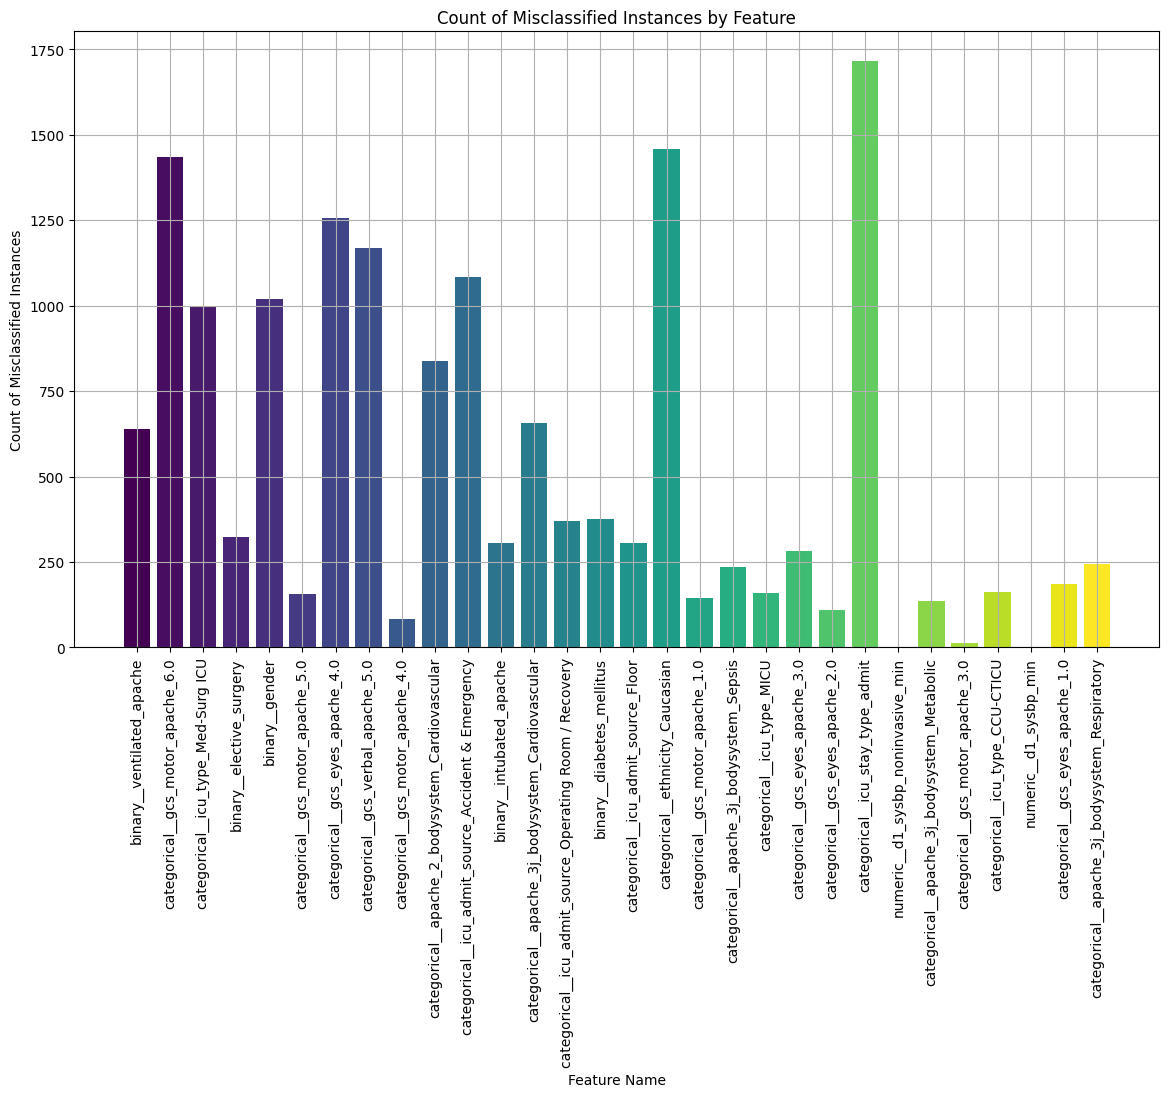

In [57]:
# initializing parameters
all_misclassified_indices = []

# Collect misclassified instances
misclassified_indices = np.where(y_valid_pred_binary != y_valid_test)[0]

# Analyze features of misclassified instances
misclassified_features = X_train_transformed_reduced[misclassified_indices]
misclassified_labels = y_train_smote.iloc[misclassified_indices]
misclassified_predictions = y_valid_pred_binary[misclassified_indices]
misclassified_feature_names = top_features

# convert to array
misclassified_features_dense = misclassified_features.toarray()

# Convert the dense array into sums of misclassified instances per feature
misclassified_counts = np.sum(misclassified_features_dense, axis=0)

# Create the plot
plt.figure(figsize=(14, 8))  # Adjust the figure size for better visibility of feature names
colors = plt.cm.viridis(np.linspace(0, 1, len(misclassified_feature_names)))  # Generate different colors for each bar

plt.bar(misclassified_feature_names, misclassified_counts, color=colors)

plt.xlabel('Feature Name')
plt.xticks(rotation=90)  # Rotate feature names to make them readable
plt.ylabel('Count of Misclassified Instances')
plt.title('Count of Misclassified Instances by Feature')

# # Add a legend outside the plot area to the right
# plt.legend(misclassified_feature_names, loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

We have tried to explore the errors in our basic model, and invastigate whether there are biased fetures, with a radical amount of mistaken classification, which might derived from measurement disorders or bias.
First, we found the idicens of samples that contains classification mistakes after training. Then, here, we present for the discovered samples, their feature distribution. For each one of the ramains feature (after feature selection and dimenionality reduce), we can see the relative amount of mistakes.
We haven't found a significant bias among one of the features (Since the higher mistake amount is approximately 1450, out of around 90000 existing samples).

# 6- Dimensionality Reduction



Truncated Singular Value Decomposition (SVD) is a dimensionality reduction technique that excels in processing sparse, high-dimensional, and skewed data.

This method is derived from singular value decomposition and is particularly adept at maintaining the essential structure and most of the variance of the input data. By capturing the most significant patterns and relationships through the largest singular values and their corresponding singular vectors, SVD effectively reduces the dimensionality of data to a more manageable and analytically efficient form.

After finding that Principal Component Analysis (PCA) was not suitable due to the sparse nature of our dataset, we opted for Truncated SVD.

Unlike PCA, which can struggle with data sparsity, SVD does not require the computation of the covariance matrix and therefore handles sparse datasets more effectively, providing a robust alternative for feature reduction in our analysis.

Cumulative Explained Variance: [0.06476717 0.41601774 0.52741385 0.59239596 0.65166466 0.69542962
 0.73170786 0.764489   0.796994   0.82367419 0.84849114 0.87142159
 0.89124799 0.90638445 0.92016071 0.93231007 0.94374006 0.9549597
 0.96532007 0.97248195 0.97940635 0.98505975 0.98926875 0.99305968
 0.99551517 0.9970403  0.99820213 0.99906923 0.99990434]


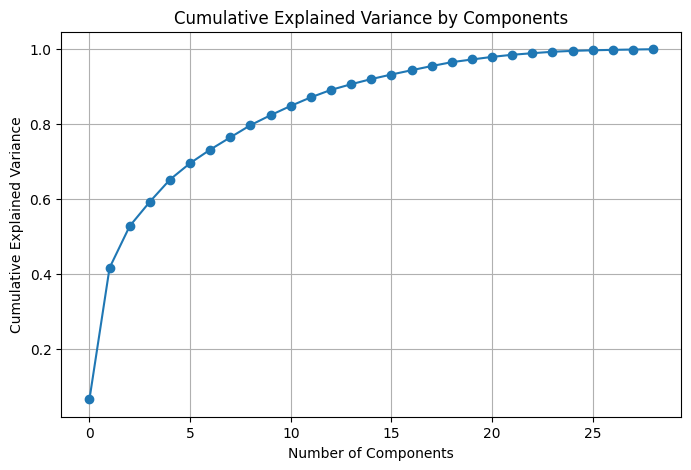

Number of components capturing at least 90% variance: 14


In [58]:
# Applying Truncated SVD
svd = TruncatedSVD(n_components=X_train_transformed_reduced.shape[1] - 1)
X_train_svd = svd.fit_transform(X_train_transformed_reduced)

# Explained variance ratio
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Components')
plt.grid(True)
plt.show()

# Selecting the number of components that explain at least 90% of the variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print("Number of components capturing at least 90% variance:", n_components)

# Re-applying SVD with optimal number of components
optimal_svd = TruncatedSVD(n_components=n_components)
X_train_svd = optimal_svd.fit_transform(X_train_transformed_reduced)
X_test_svd = optimal_svd.transform(X_test_reduced)

In [59]:
# Evaluate the model's predictive results in a 10 fold cross-validation process after applying feature selection

scoring = ['accuracy', 'roc_auc']
cv_results = cross_validate(model, X_train_transformed_reduced, y_train_smote, cv=cv, scoring=scoring)

print(f"Accuracy mean: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Roc Auc mean: {np.mean(cv_results['test_roc_auc']):.4f}")

Accuracy mean: 0.9522
Roc Auc mean: 0.9826


# 7- Hyper parameter tuning + performing a new improved model

Extreme Gradient Boosting (XGBoost) is an efficient implementation of the gradient boosting algorithm, which builds multiple decision trees sequentially. Each tree is trained to correct the errors made by the previous trees, and gradually improving the overall model's performance.

The model has variety of hyper-parameter that can adjust corresponding to reqierments and affect the model performance.
We chose to optimize the following parameters:
1. max_depth: specifies the maximum depth of each decision tree in the ensemble. Deeper trees can capture more complex patterns in the data but may also lead to overfitting.
2. Learning Rate: controls the contribution of each tree to the ensemble. A lower learning rate requires more trees to achieve the same level of model performance but can improve generalization.
3. n_estimators: This hyperparameter determines the number of trees to be built. A higher number of boosting rounds can improve the model's performance, but it also increases the risk of overfitting.
4. Subsample: This hyperparameter specifies the fraction of training data to be used for each boosting round. It can help prevent overfitting by introducing randomness into the training process.
5. colsample_bytree: controls the fraction of features (columns) to be randomly sampled for each tree. It helps introduce diversity into the ensemble and can reduce overfitting.
6. Gamma: Specifies the minimum reduction in the loss function required to make a further partition on a leaf node of the tree. It acts as regularization by controlling the tree's growth and can prevent overfitting.
7. min_child_weight: Specifies the minimum sum of instance weight (hessian) needed in a child (leaf) node. It helps control the tree's complexity and can prevent overfitting by requiring a minimum amount of data in each leaf node.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Score: 0.8629494566616976
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Score: 0.862977426081677
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Score: 0.8631079435234206
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Score: 0.8627629769146236
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Score: 0.8627257425835376
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Score: 0.8637791900484435
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'learn

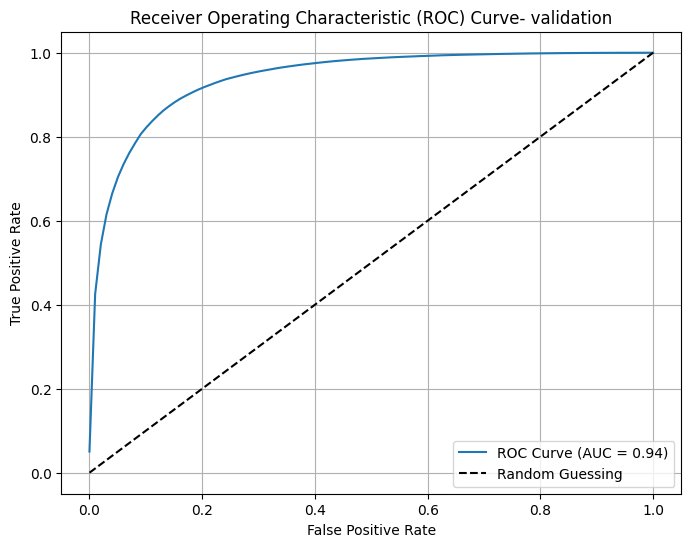

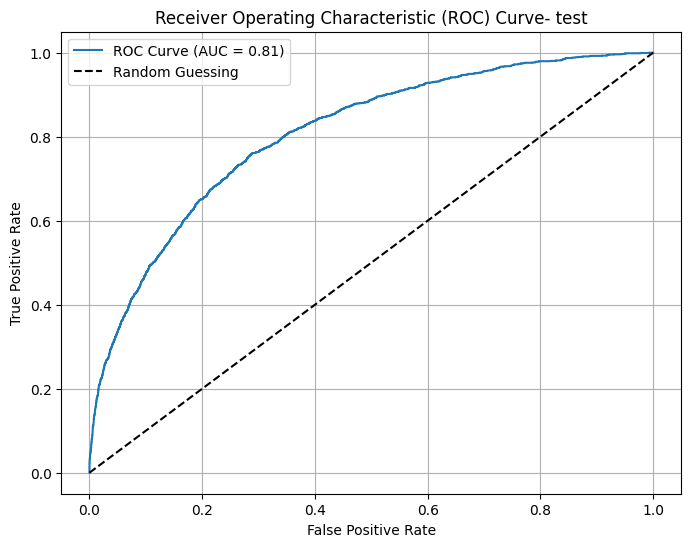

In [60]:
# Performing an XGBoost classifier

# Define model
model = xgb.XGBClassifier(random_state=42, reg_lambda=2)

# Define parameters for hyper-parameters tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    # 'n_estimators': [100, 200, 300],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'min_child_weight': [1, 3, 5]
}

# performing 10-cross validation process
cv_auc_scores = []
interpolated_fpr_scores = []
interpolated_tpr_scores = []

counter = 0

while counter < 10:
  # dividing to validation and training sets
  X_valid_train, X_valid_test, y_valid_train, y_valid_test = train_test_split(X_train_svd, y_train_smote, test_size=0.2)

  # Apply preprocessing on validation and test data
  X_valid_train_transformed = X_valid_train
  X_valid_test_transformed = X_valid_test

  # Hyperparameter tuning using GridSearchCV
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-2)
  grid_search.fit(X_valid_train_transformed, y_valid_train)

  # Get the best hyperparameters
  best_params = grid_search.best_params_
  best_score = grid_search.best_score_
  print("Best Hyperparameters:", best_params)
  print("Best Score:", best_score)

  # Training the model with best hyperparameters
  model.set_params(**best_params)
  model.fit(X_valid_train_transformed, y_valid_train)

  # Predict probabilities on the test set
  y_pred = model.predict_proba(X_valid_test_transformed)

  # Compute AUC score for this fold

  auc_score = roc_auc_score(y_valid_test, y_pred[:, 1])
  cv_auc_scores.append(auc_score)

  fpr, tpr, thresholds = roc_curve(y_valid_test, y_pred[:,1])
  interpolated_fpr = np.linspace(0, 1, 100)  # Define the desired number of points for FPR
  interpolated_tpr = np.interp(interpolated_fpr, fpr, tpr)  # Interpolate TPR values
  interpolated_fpr_scores.append(interpolated_fpr)
  interpolated_tpr_scores.append(interpolated_tpr)

  counter += 1

# compute mean AUC, fpr, tpr
mean_auc = np.mean(cv_auc_scores)
mean_fpr = np.mean(interpolated_fpr_scores, axis=0)
mean_tpr = np.mean(interpolated_tpr_scores, axis=0)

# Examine the model performance on test set
y_pred = model.predict_proba(X_test_svd)
auc_score = roc_auc_score(y_test, y_pred[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])

# Plot ROC curve

# mean validation set
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label='ROC Curve (AUC = {:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- validation')
plt.legend()
plt.grid(True)
plt.show()

# test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- test')
plt.legend()
plt.grid(True)
plt.show()

Due to memory considerations, derived from our big amount of smples, we decided to use descrete values for the optimizing. Still, we eventialy could not optimaized the whole hyper-parameter as we aim to.
Morover, altoght the diversity of method we tried in order to improve our model performance, we didn't success to do so.

Since we checked and had some research regarding the correct process for handling complex data as ours, we decided to not exclude important steps from our analyze (e.g. even though the imbalance values handling might cause a suspection to overfitting, we could not ignore the bias we could have gotten in our results if we would had dismissed the dealing with this part).

Over all, we decided to try and perform a good and correct process, rather than improve the basic results.

# Model explanability

100%|===================| 133994/134084 [15:55<00:00]       

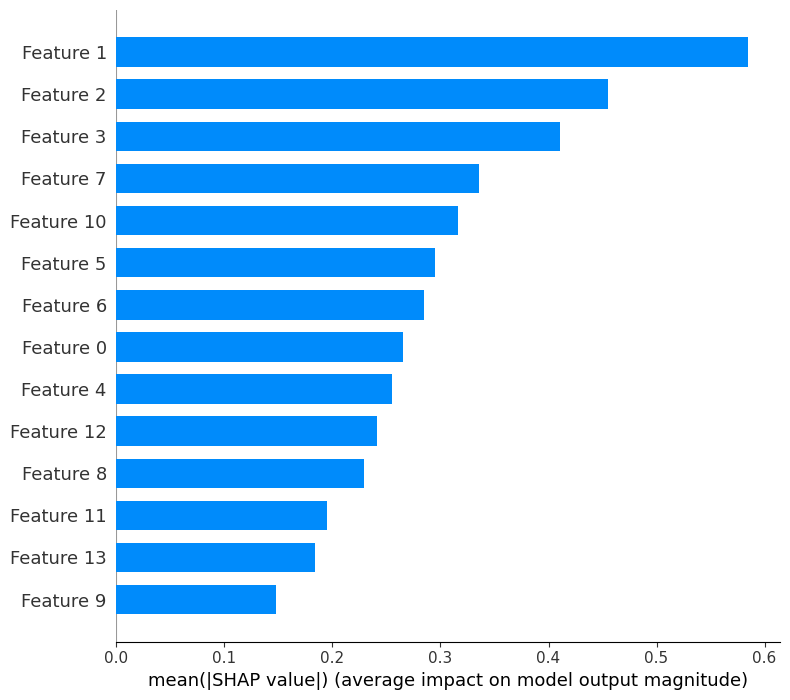

In [61]:
# Create the SHAP Explainer
explainer = shap.Explainer(model, X_train_svd)

# Calculate SHAP values
shap_values = explainer(X_train_svd)

# Generate a summary bar plot of the SHAP values
shap.summary_plot(shap_values, X_train_svd, plot_type="bar")

SHAP values offer insights into how each feature in the dataset contributes, either positively or negatively, to the target variable.
Since in our final model, we used the transformed fetures after applying SVD (please see above), we can not relate to the final importance of each original feature. Though, we can see the decesndent contribution of each combination of features.  In addition, we can see the original features importance in the previous analyze (step .

# Discussion and final thoughts

In this project, we tackled a high-dimensional dataset characterized by significant computational demands and complexity.

The focus was on intelligent feature selection, dimensionality reduction, and meticulous outlier management within clinical data, critical for maintaining data integrity.

 Throughout the model development phase, we engaged in an iterative process involving extensive experimentation with various standard methodologies that, upon application, proved unsuitable for our specific dataset. This often resulted in models that were either underperforming or overly optimistic, suggesting significant overfitting issues.

To address these challenges, we consistently consulted scientific literature to refine our strategies and develop an optimized modeling pipeline in order to enhanced the model's predictive performance and its capability to generalize effectively across real-world scenarios — a crucial aspect given the extensive feature set.

Key strategies employed included:

Adaptive Outlier Management:
1. Tailored specifically for clinical contexts to preserve vital extreme data points essential for accurate predictions.
2. Strategic Feature Selection: Focused on leveraging features that substantially contribute to model accuracy.
3. Error Management: Systematic identification and correction of prediction errors.
4. Balancing Techniques: Application of appropriate methods to address the considerable class imbalance in the dataset.
5. Advanced Dimensionality Reduction: Implementation of techniques like Singular Value Decomposition (SVD), chosen over more conventional methods such as PCA, to better handle the non-uniform and multi-dimensional nature of our data.

Despite the progress made, there remains a substantial scope for further learning and enhancement of the model. As we mentioned, we decided to handle both the data and model in the correct way as we understand and read in litreture. Even thought we did not succeed to improve the model results as we aimed. The finalized pipeline, however, represent a significant step towards achieving a relibale model, while robusting predictive accuracy and model generalizability.